# 1. Importing libraries and loading Data

### 1.1 Installing necessary libraries


In [2]:
"""
%pip install emoji
%pip install tensorflow
%pip install transformers
%pip install pandas
%pip install sklearn
%pip install matplotlib
%pip install seaborn
"""


'\n%pip install emoji\n%pip install tensorflow\n%pip install transformers\n%pip install pandas\n%pip install sklearn\n%pip install matplotlib\n%pip install seaborn\n'

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import emoji
import re
import string
from transformers import TFBertModel, BertTokenizerFast, BertConfig
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, BatchNormalization
from keras.models import Model
from sklearn.metrics import f1_score, recall_score, precision_score
from tensorflow.keras.utils import plot_model
from keras.initializers import TruncatedNormal
import keras.backend as K

### 1.2 Plot Defaults


In [2]:
colors = sns.color_palette('rocket_r')
sns.set_palette('rocket_r')

### 1.3 Helper Functions

In [11]:
def idx2class(idx_list):
    """
    This function converts a list of class indices to a list of class labels.

    Parameters
    ----------
    idx_list : list
        List of class indices.
    
    Returns
    -------
    class_list : list
        List of class labels.
    """
    arr = []
    for i in idx_list:
        arr.append(labels[int(i)])
    return arr

def EmotionMapping(list_of_emotions):
    list = []  
    for i in list_of_emotions:
        if i in ekman_map['anger']:
            list.append('anger')
        if i in ekman_map['disgust']:
            list.append('disgust')
        if i in ekman_map['fear']:
            list.append('fear')
        if i in ekman_map['joy']:
            list.append('joy')
        if i in ekman_map['sadness']:
            list.append('sadness')
        if i in ekman_map['surprise']:
            list.append('surprise')
        if i == 'neutral':
            list.append('neutral')      
    return list

def SentimentMapping(list_of_emotions):
    list = []  
    for i in list_of_emotions:
        if i in sentiment_map['positive']:
            list.append('positive')
        if i in sentiment_map['negative']:
            list.append('negative')
        if i in sentiment_map['ambiguous']:
            list.append('ambiguous')
    return list

### 1.4 Loading data

In [3]:
train_url = 'https://github.com/google-research/google-research/raw/master/goemotions/data/train.tsv'
valid_url = 'https://github.com/google-research/google-research/raw/master/goemotions/data/dev.tsv'
test_url = 'https://github.com/google-research/google-research/raw/master/goemotions/data/test.tsv'

In [4]:
train_df = pd.read_csv(train_url, sep='\t', encoding='utf-8',
                       names=['text', 'emotion', 'annotator'], header=None)
valid_df = pd.read_csv(valid_url, sep='\t', encoding='utf-8',
                       names=['text', 'emotion', 'annotator'], header=None)
test_df = pd.read_csv(test_url, sep='\t', encoding='utf-8',
                      names=['text', 'emotion', 'annotator'], header=None)

In [5]:
train_df.head(2)

,text,emotion,annotator
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43410 entries, 0 to 43409
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       43410 non-null  object
 1   emotion    43410 non-null  object
 2   annotator  43410 non-null  object
dtypes: object(3)
memory usage: 1017.5+ KB


### 1.5 Preprocessing

Column 2 "annotator" is unnecessary, so we can drop it.


In [7]:
train_df.drop('annotator', axis=1, inplace=True)
valid_df.drop('annotator', axis=1, inplace=True)
test_df.drop('annotator', axis=1, inplace=True)

Dictionaries for mapping emotions to indices and vice versa. 

The variable `ekman_map` is used to map 27 emotions to 7 emotions. This is done to reduce the number of classes.

The 27 emotions can also be mapped to the 3 emotions using the `sentiment_map` dictionary for sentiment analysis tasks.


In [8]:
labels = {
    0: 'admiration',
    1: 'amusement',
    2: 'anger',
    3: 'annoyance',
    4: 'approval',
    5: 'caring',
    6: 'confusion',
    7: 'curiosity',
    8: 'desire',
    9: 'disappointment',
    10: 'disapproval',
    11: 'disgust',
    12: 'embarrassment',
    13: 'excitement',
    14: 'fear',
    15: 'gratitude',
    16: 'grief',
    17: 'joy',
    18: 'love',
    19: 'nervousness',
    20: 'optimism',
    21: 'pride',
    22: 'realization',
    23: 'relief',
    24: 'remorse',
    25: 'sadness',
    26: 'surprise',
    27: 'neutral'
}

ekman_map = {
    'anger': ['anger', 'annoyance', 'disapproval'],
    'disgust': ['disgust'],
    'fear': ['fear', 'nervousness'],
    'joy': ['joy', 'amusement', 'approval', 'excitement', 'gratitude',  'love', 'optimism', 'relief', 'pride', 'admiration', 'desire', 'caring'],
    'sadness': ['sadness', 'disappointment', 'embarrassment', 'grief',  'remorse'],
    'surprise': ['surprise', 'realization', 'confusion', 'curiosity'],
    'neutral': ['neutral']
}

sentiment_map = {
    "positive": ["amusement", "excitement", "joy", "love", "desire", "optimism", "caring", "pride", "admiration", "gratitude", "relief", "approval"],
    "negative": ["fear", "nervousness", "remorse", "embarrassment", "disappointment", "sadness", "grief", "disgust", "anger", "annoyance", "disapproval"],
    "ambiguous": ["realization", "surprise", "curiosity", "confusion", "neutral"]
}

First, let's extract all emotions from the each example and store them in a list.

In [9]:
train_df['list of emotions'] = train_df['emotion'].apply(lambda x: x.split(','))
test_df['list of emotions'] = test_df['emotion'].apply(lambda x: x.split(','))
valid_df['list of emotions'] = valid_df['emotion'].apply(lambda x: x.split(','))

We can then apply index to class mapping to get the class labels for each row

In [12]:
train_df['emotion'] = train_df['list of emotions'].apply(lambda x: idx2class(x))
test_df['emotion'] = test_df['list of emotions'].apply(lambda x: idx2class(x))
valid_df['emotion'] = valid_df['list of emotions'].apply(lambda x: idx2class(x))

Finally, we can reduce the number of classes to 7 by using the EmotionMapping function.

In [13]:
train_df['ekman_emotion'] = train_df['emotion'].apply(lambda x: EmotionMapping(x))
test_df['ekman_emotion'] = test_df['emotion'].apply(lambda x: EmotionMapping(x))
valid_df['ekman_emotion'] = valid_df['emotion'].apply(lambda x: EmotionMapping(x))

In [14]:
train_df.head(10)

,text,emotion,list of emotions,ekman_emotion
0,My favourite food is anything I didn't have to...,[neutral],[27],[neutral]
1,"Now if he does off himself, everyone will thin...",[neutral],[27],[neutral]
2,WHY THE FUCK IS BAYLESS ISOING,[anger],[2],[anger]
3,To make her feel threatened,[fear],[14],[fear]
4,Dirty Southern Wankers,[annoyance],[3],[anger]
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,[surprise],[26],[surprise]
6,Yes I heard abt the f bombs! That has to be wh...,[gratitude],[15],[joy]
7,We need more boards and to create a bit more s...,"[desire, optimism]","[8, 20]","[joy, joy]"
8,Damn youtube and outrage drama is super lucrat...,[admiration],[0],[joy]
9,It might be linked to the trust factor of your...,[neutral],[27],[neutral]


In [15]:
def clean_text(text):
    """
    This function cleans the text in the dataframe and returns a list of cleaned text.
    text: a string

    return: modified initial string
    """
    # Removing Emojis
    text = emoji.demojize(text)  # remove emojis
    text = str(text).lower()  # text to lower case
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)  # remove punctuation
    return text

One hot encoding of emotions 

In [16]:
for i in ekman_map:
    train_df[i] = train_df['ekman_emotion'].apply(lambda x: 1 if i in x else 0)
    test_df[i] = test_df['ekman_emotion'].apply(lambda x: 1 if i in x else 0)
    valid_df[i] = valid_df['ekman_emotion'].apply(lambda x: 1 if i in x else 0)

In [63]:
train_df.head(10)

,text,emotion,list of emotions,ekman_emotion,anger,disgust,fear,joy,sadness,surprise,neutral
0,My favourite food is anything I didn't have to...,[neutral],[27],[neutral],0,0,0,0,0,0,1
1,"Now if he does off himself, everyone will thin...",[neutral],[27],[neutral],0,0,0,0,0,0,1
2,WHY THE FUCK IS BAYLESS ISOING,[anger],[2],[anger],1,0,0,0,0,0,0
3,To make her feel threatened,[fear],[14],[fear],0,0,1,0,0,0,0
4,Dirty Southern Wankers,[annoyance],[3],[anger],1,0,0,0,0,0,0
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,[surprise],[26],[surprise],0,0,0,0,0,1,0
6,Yes I heard abt the f bombs! That has to be wh...,[gratitude],[15],[joy],0,0,0,1,0,0,0
7,We need more boards and to create a bit more s...,"[desire, optimism]","[8, 20]","[joy, joy]",0,0,0,1,0,0,0
8,Damn youtube and outrage drama is super lucrat...,[admiration],[0],[joy],0,0,0,1,0,0,0
9,It might be linked to the trust factor of your...,[neutral],[27],[neutral],0,0,0,0,0,0,1


### 1.6 Visualization

Bar plot of distribution of emotions

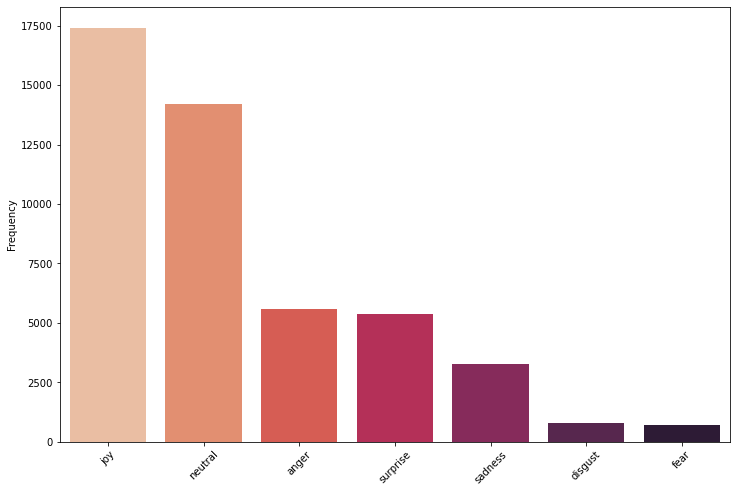

In [17]:
labels_summary = train_df.iloc[:, 4:].sum()
labels_summary.sort_values(ascending=False, inplace=True)

fig = plt.figure(figsize=(12, 8))
sns.barplot(x=labels_summary.index,
            y=labels_summary.values, palette='rocket_r')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.show()

Number of emotions in each sample

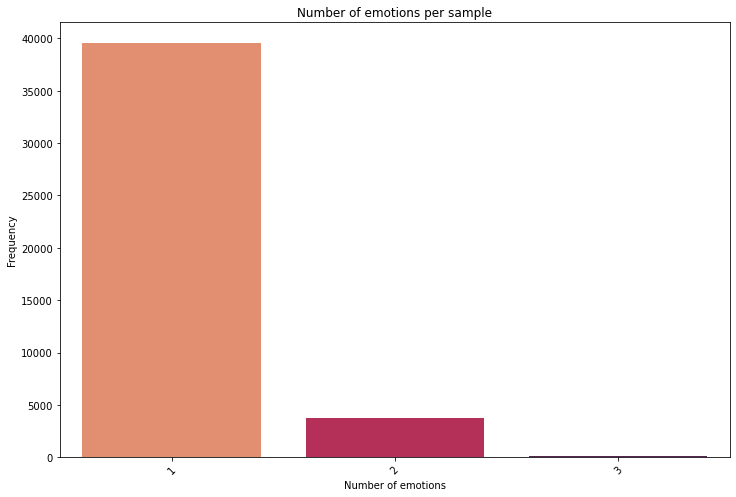

In [18]:
train_df['n_emotions'] = train_df.iloc[:, 4:].apply(lambda x: x.sum(), axis=1)

fig = plt.figure(figsize=(12, 8))
sns.countplot(x='n_emotions', data=train_df, palette='rocket_r')
plt.xticks(rotation=45)
plt.title('Number of emotions per sample')
plt.ylabel('Frequency')
plt.xlabel('Number of emotions')
plt.show()

Distribution of text length in the train set

<Figure size 864x720 with 0 Axes>

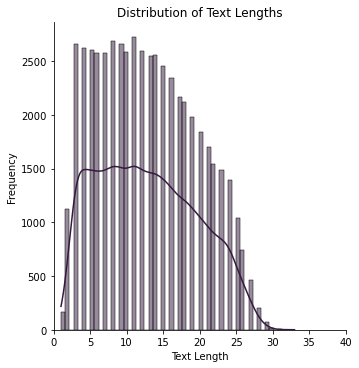

In [19]:
full_text = pd.concat([train_df['text'], valid_df['text'], test_df['text']])
lengths = full_text.apply(lambda x: len(x.split()))
fig = plt.figure(figsize=(12, 10))
sns.displot(lengths, kde=True, rug=False, color=colors[5])
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.xlim(0, 40)
plt.show()

# 2. Model

### 2.1 Base model config

#### Computing max length of samples

`max_length` variable is used to limit the length of the input text that is fed to the model. The sequence will be padded with the `<PAD>` token if the length of the sequence is less than `max_length` and the sequence will be truncated if the length of the sequence is more than `max_length`. This is done to ensure that the model can handle any size of input text.

In [20]:
full_text = pd.concat([train_df['text'], valid_df['text'], test_df['text']])
max_length = full_text.apply(lambda x: len(x.split())).max()
max_length

33

I am going to use Google's BERT base model which contains 110M parameters.

In [21]:
model_name = 'bert-base-uncased'
config = BertConfig.from_pretrained(model_name, output_hidden_states=False)
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### 2.2 Model architecture

model takes three inputs that result from tokenization:

- `input_ids`: indices of input sequence tokens in the vocabulary
- `token_type_ids`: Segment token indices to indicate first and second portions of the inputs. 0 for sentence A and 1 for sentence B
- `attention mask`: Mask to avoid performing attention on padding token indices. 0 for masked and 1 for not masked

I have a sigmoided output layer in the model because it is more appropriate than a softmax layer. This is because I are trying to predict the probability of each label and not the label itself.


In [22]:
def my_model(n_labels):

  # Load the MainLayer
  bert = transformer_model.layers[0]

  ## INPUTS
  input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
  attention_mask = Input(shape=(max_length,), name='attention_mask', dtype='int32')
  token_type_ids = Input(shape=(max_length,), name='token_type_ids', dtype='int32')
  inputs = {'input_ids': input_ids, 'attention_mask': attention_mask, 'token_type_ids': token_type_ids}

  ## LAYERS
  bert_model = bert(inputs)[1]
  dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
  pooled_output = dropout(bert_model, training=False)

  ## OUTPUT
  emotion = Dense(units=n_labels, activation='sigmoid', kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='emotion')(pooled_output)
  outputs = emotion

  model = Model(inputs=inputs, outputs=outputs, name='BERT_Emotion_Classifier')

  return model

In [25]:
model = my_model(len(ekman_map))
model.summary()

Model: "BERT_Emotion_Classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 33)]         0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 33)]         0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 33)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['attention_mask[0][0]',         
                                thPoolingAndCrossAt               'input_ids

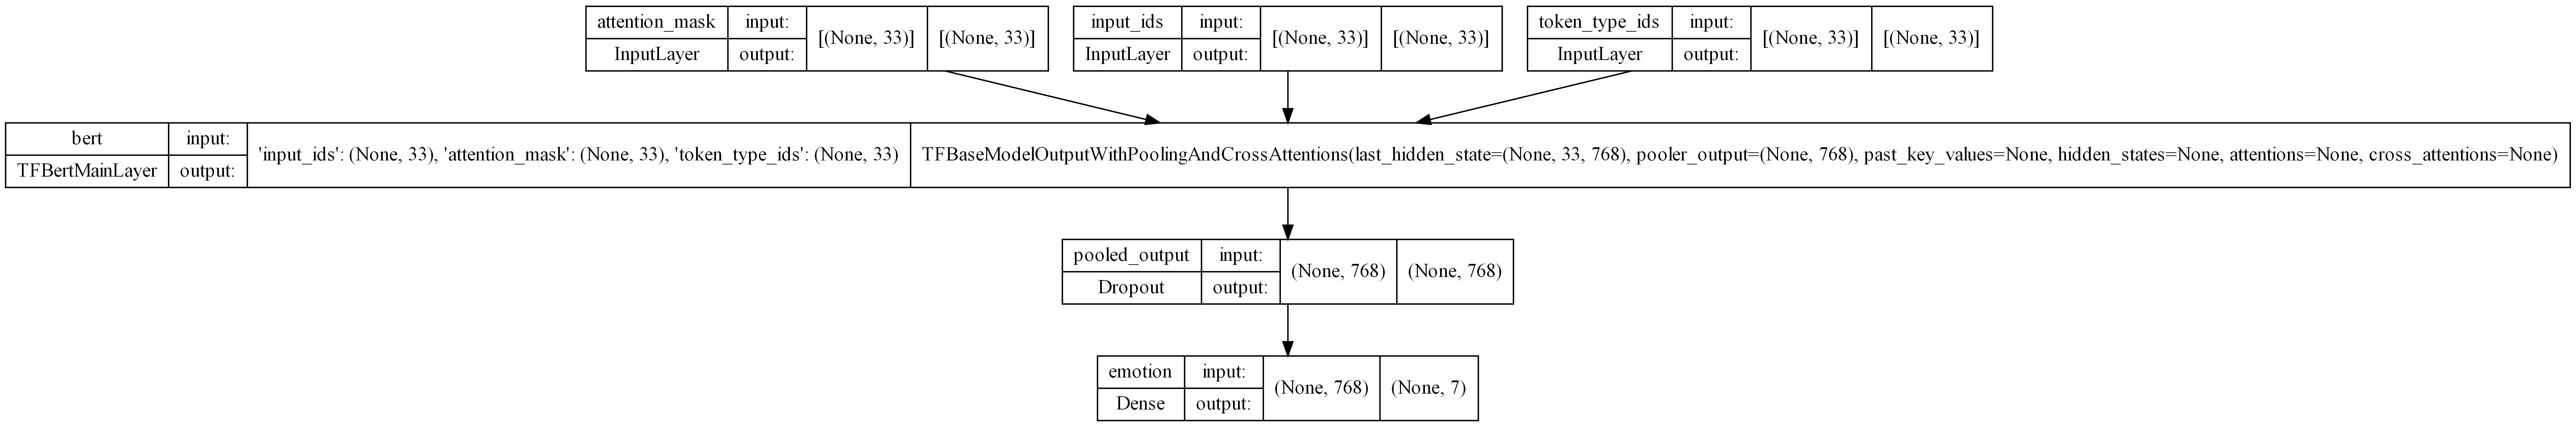

In [26]:
plot_model(model, show_shapes=True, dpi=300)

### 2.3 Data tokenization

In [23]:
## Train 
x_train = train_df['text']
y_train = train_df.loc[:, ekman_map.keys()].values

train_tokenized = tokenizer(
    text = list(x_train),
    add_special_tokens = True,
    max_length = max_length,
    padding = 'max_length',
    truncation = True,
    return_tensors = 'tf',
    return_attention_mask = True,
    return_token_type_ids = True
)

## Test
x_test = test_df['text']
y_test = test_df.loc[:, ekman_map.keys()].values

test_tokenized = tokenizer(
    text = list(x_test),
    add_special_tokens = True,
    max_length = max_length,
    padding = 'max_length',
    truncation = True,
    return_tensors = 'tf',
    return_attention_mask = True,
    return_token_type_ids = True
)

## Validation
x_valid = valid_df['text']
y_valid = valid_df.loc[:, ekman_map.keys()].values

valid_tokenized = tokenizer(
    text = list(x_valid),
    add_special_tokens = True,
    max_length = max_length,
    padding = 'max_length',
    truncation = True,
    return_tensors = 'tf',
    return_attention_mask = True,
    return_token_type_ids = True
)

### 2.4 Creating BERT compatible inputs

In [24]:
tf_train = {'input_ids': train_tokenized['input_ids'], 'attention_mask': train_tokenized['attention_mask'], 'token_type_ids': train_tokenized['token_type_ids']}
tf_test = {'input_ids': test_tokenized['input_ids'], 'attention_mask': test_tokenized['attention_mask'], 'token_type_ids': test_tokenized['token_type_ids']}
tf_valid = {'input_ids': valid_tokenized['input_ids'], 'attention_mask': valid_tokenized['attention_mask'], 'token_type_ids': valid_tokenized['token_type_ids']}

In [25]:
train = tf.data.Dataset.from_tensor_slices((tf_train, y_train)).batch(80)
valid = tf.data.Dataset.from_tensor_slices((tf_valid, y_valid)).batch(80)
test = tf.data.Dataset.from_tensor_slices((tf_test, y_test)).batch(80)

In [27]:
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-5,
    decay_rate=0.7,
    decay_steps=340,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [31]:
K.clear_session()

Prior experiments with BERT showed that the model starts to overfit after ~2 epochs and Tanh performed significantly worse than sigmoid.

In [ ]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
history = model.fit(train, epochs=2, validation_data=valid)

In [ ]:
model.save_weights('./models/sigmoid_bert.h5')

# 3. Evaluation

When dealing with unbalanced data, it is essential to mini-batch train the model instead of training it on all the data. This helps to prevent the model from overfitting the minority class. It is also essential to be thoughtful about what metric is being used for model evaluation. When dealing with unbalanced data, accuracy is not a good metric, as the model can predict the majority class every time and still have high accuracy. Instead, it is crucial to use the precision/recall or the F1 score, as these metrics consider false positives and false negatives.


In [28]:
model = my_model(len(ekman_map))
model.load_weights('./models/sigmoid_bert.h5')

In [270]:
THRESHOLD = 0.83

y_pred = model.predict(test)

In [272]:
probabilities = y_pred

probabilities = pd.DataFrame(probabilities, columns=ekman_map.keys())
probabilities.index = x_test
probabilities.reset_index(inplace=True)
probabilities.head(10)

,text,anger,disgust,fear,joy,sadness,surprise,neutral
0,I’m really sorry about your situation :( Altho...,0.011721,0.005526,0.009489,0.333413,0.908717,0.023670,0.015264
1,It's wonderful because it's awful. At not with.,0.090920,0.425903,0.074700,0.881766,0.035821,0.027443,0.014918
2,"Kings fan here, good luck to you guys! Will be...",0.007555,0.001614,0.001274,0.980743,0.003579,0.010421,0.021167
3,"I didn't know that, thank you for teaching me ...",0.010060,0.002248,0.003295,0.974120,0.008027,0.274153,0.009904
4,They got bored from haunting earth for thousan...,0.153944,0.034610,0.012113,0.044413,0.217566,0.019571,0.637800
5,Thank you for asking questions and recognizing...,0.010523,0.002019,0.002120,0.989072,0.004201,0.042558,0.009365
6,You’re welcome,0.006238,0.001227,0.000976,0.960289,0.003087,0.005575,0.047323
7,100%! Congrats on your job too!,0.008894,0.001032,0.000608,0.959041,0.002684,0.007411,0.043967
8,I’m sorry to hear that friend :(. It’s for the...,0.014285,0.006906,0.009549,0.128064,0.924843,0.020818,0.025940
9,"Girlfriend weak as well, that jump was pathetic.",0.048291,0.038965,0.010835,0.054523,0.872390,0.007691,0.056577


In [274]:
y_pred = np.where(y_pred > THRESHOLD, 1, 0)

recall = []
f1 = []
precision = []
emotions = ekman_map.keys()

for i in range(len(emotions)):
    f1.append(f1_score(y_test[:, i], y_pred[:, i], average='macro'))
    precision.append(precision_score(y_test[:, i], y_pred[:, i], average='macro'))

results = pd.DataFrame({'precision': precision, 'f1': f1})
results.index = emotions

means = {'precision': np.mean(precision), 'f1': np.mean(f1)}
means = pd.DataFrame(means, index=['mean'])


In [275]:
pd.concat([results, means], axis=0)

,precision,f1
anger,0.850139,0.608628
disgust,0.988938,0.518217
fear,0.922815,0.753969
joy,0.871704,0.841515
sadness,0.887779,0.723279
surprise,0.836967,0.636299
neutral,0.775999,0.544398
mean,0.876334,0.660901


### 3.1 Optimization

Finding the best value of Threshold. I chose f1-score as the main metric because it is more robust than precision and recall alone.

In [276]:
best_threshold = 0
best_f1 = 0
pred = model.predict(test)

for threshold in np.arange(0.30, 0.99, 0.01):
    preds = np.where(pred > threshold, 1, 0)

    f1 = f1_score(y_test, preds, average='macro', zero_division=0)

    if f1 > best_f1:
        best_threshold = threshold
        best_f1 = f1
    else:
        continue

In [201]:
print(f'Best threshold: {best_threshold}\nBest f1: {best_f1}')

Best threshold: 0.39000000000000007
Best f1: 0.6318331819845665


In [277]:
THRESHOLD = 0.39

## 4. Make Predictions

In [278]:
def pred(text, model, THRESHOLD):

    text = [clean_text(text) for text in text]
    
    tokenized = tokenizer(
        text = text,
        add_special_tokens = True,
        max_length = max_length,
        padding = 'max_length',
        truncation = True,
        return_tensors = 'tf',
        return_attention_mask = True,
        return_token_type_ids = True
    )

    tf_test = {'input_ids': tokenized['input_ids'], 'attention_mask': tokenized['attention_mask'], 'token_type_ids': tokenized['token_type_ids']}

    pred = model.predict(tf_test)

    probabilities = pred
    probabilities = pd.DataFrame(probabilities, columns=ekman_map.keys())
    probabilities.index = text
    probabilities.reset_index(inplace=True)

    pred = np.where(pred > THRESHOLD, 1, 0)

    pred = pd.DataFrame(pred, columns=ekman_map.keys())
    pred['emotion'] = pred.iloc[:, 1:].idxmax(axis=1)
    pred.drop(columns=emotions, inplace=True)
    pred.index = text
    pred.reset_index(inplace=True)

    return pred, probabilities

In [296]:
result, probabilities = pred(['A Ukrainian woman who escaped Russias assault on Mariupol says troops were targeting apartment buildings as if they were playing a computer game', 'I often go to parks to walk and destress and enjoy nature', 'How can this be', 'This is the worst muffin ive ever had'], model, THRESHOLD)

In [297]:
result

,index,emotion
0,a ukrainian woman who escaped russias assault ...,neutral
1,i often go to parks to walk and destress and e...,joy
2,how can this be,surprise
3,this is the worst muffin ive ever had,disgust


In [298]:
probabilities


,index,anger,disgust,fear,joy,sadness,surprise,neutral
0,a ukrainian woman who escaped russias assault ...,0.087899,0.016457,0.013741,0.059171,0.037938,0.035673,0.771584
1,i often go to parks to walk and destress and e...,0.005118,0.000891,0.000841,0.948705,0.002574,0.017889,0.060095
2,how can this be,0.057721,0.005070,0.005864,0.007708,0.015448,0.712940,0.290443
3,this is the worst muffin ive ever had,0.263611,0.804038,0.069563,0.053430,0.088046,0.035055,0.072389
